<a href="https://colab.research.google.com/github/awesomemj/capstone_fa2024/blob/main/Price_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [2]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.9 MB/s eta 0:00:00


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

Import cleaned data

In [4]:
df = pd.read_csv('BACKUP cleaned_zillow_data.csv')
print(df.shape)
df.head()

(128960, 117)


,Unnamed: 0,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,...,ngram_indooroutdoor,ngram_court,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian
0,2,23352313.0,FOR_SALE,7001 Palm Lane,Anacortes,WA,98221.0,2498000.0,4.0,3.0,...,0,1,0,0,0,0,0,0,0,0
1,3,23380009.0,FOR_SALE,14820 Gibralter Road,Anacortes,WA,98221.0,5300000.0,5.0,6.0,...,0,0,0,0,0,0,0,0,0,0
2,4,23352179.0,FOR_SALE,7270 Old Brook Lane,Anacortes,WA,98221.0,1499000.0,5.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,6,23377187.0,FOR_SALE,13574 S Green Street,Anacortes,WA,98221.0,399000.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,9,23377249.0,FOR_SALE,13590 Slice Street,Anacortes,WA,98221.0,1250000.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df[['city', 'state', 'homeType']].head()

,city,state,homeType
0,Anacortes,WA,SingleFamily
1,Anacortes,WA,SingleFamily
2,Anacortes,WA,SingleFamily
3,Anacortes,WA,SingleFamily
4,Anacortes,WA,SingleFamily


In [6]:
stl_sf = pd.read_csv('stl_single_family.csv')
stl_mf = pd.read_csv('stl_multi_family.csv')
stl_cc = pd.read_csv('stl_condo_coop.csv')
stl_th = pd.read_csv('stl_townhouse.csv')

In [7]:
stl = stl_sf.merge(stl_mf, how='outer', on = ['city', 'state'])
stl = stl.merge(stl_cc, how='outer', on = ['city', 'state'])
stl = stl.merge(stl_th, how='outer', on = ['city', 'state'])

print(stl.shape)
stl.head()

(21274, 6)


,city,state,singel_family,multifamily,condo_coop,townhouse
0,Aaronsburg,PA,97.7%,NaN,NaN,NaN
1,Abbeville,AL,82.1%,NaN,NaN,NaN
2,Abbeville,LA,97.4%,NaN,NaN,NaN
3,Abbotsford,WI,88.1%,NaN,NaN,NaN
4,Abbottstown,PA,102.2%,NaN,NaN,NaN


In [8]:
# Reshape the DataFrame using melt
stl_melted = stl.melt(id_vars=["city", "state"],
                    value_vars=["singel_family", "multifamily", "condo_coop", "townhouse"],
                    var_name="homeType",
                    value_name="sale_to_list")

# Drop rows with NaN in the 'sale_to_list' column
stl_melted = stl_melted.dropna(subset=["sale_to_list"])

# Clean up the 'homeType' column to remove any typos or inconsistencies, if needed
stl_melted['homeType'] = stl_melted['homeType'].replace({"singel_family": "singlefamily"})

print(stl_melted.shape)
stl_melted.head()

(22271, 4)


,city,state,homeType,sale_to_list
0,Aaronsburg,PA,singlefamily,97.7%
1,Abbeville,AL,singlefamily,82.1%
2,Abbeville,LA,singlefamily,97.4%
3,Abbotsford,WI,singlefamily,88.1%
4,Abbottstown,PA,singlefamily,102.2%


In [9]:
df['homeType'] = df['homeType'].str.lower().str.replace(" ", "")
df['city'] = df['city'].str.strip()
df['state'] = df['state'].str.strip()
stl_melted['homeType'] = stl_melted['homeType'].str.lower().str.replace(" ", "")
stl_melted['city'] = stl_melted['city'].str.strip()
stl_melted['state'] = stl_melted['state'].str.strip()

In [10]:
df_stl = df.merge(stl_melted, how='left', on = ['city', 'state', 'homeType'])
print(df_stl.shape)
df_stl[['city', 'state', 'homeType', 'sale_to_list']].head()

(128960, 118)


,city,state,homeType,sale_to_list
0,Anacortes,WA,singlefamily,99.4%
1,Anacortes,WA,singlefamily,99.4%
2,Anacortes,WA,singlefamily,99.4%
3,Anacortes,WA,singlefamily,99.4%
4,Anacortes,WA,singlefamily,99.4%


In [11]:
state_avg = stl_melted[stl_melted['state'].isnull()].reset_index(drop=True)

state_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA",
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO",
    "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
    "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT",
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
    "District of Columbia": "DC"
}

# Fill 'state' column with the mapped values from 'city' where 'state' is null
state_avg['state'] = state_avg.apply(lambda row: state_abbrev.get(row['city'], row['state']) if pd.isnull(row['state']) else row['state'], axis=1)

print(state_avg.shape)
state_avg.head()

(193, 4)


,city,state,homeType,sale_to_list
0,Alabama,AL,singlefamily,97.6%
1,Alaska,AK,singlefamily,99.1%
2,Arizona,AZ,singlefamily,98.3%
3,Arkansas,AR,singlefamily,97.3%
4,California,CA,singlefamily,100.2%


In [12]:
df_stl = df_stl.merge(
    state_avg[['state', 'homeType', 'sale_to_list']],
    on=['state', 'homeType'],
    how='left',
    suffixes=('', '_state_avg')
)

# Fill missing `sale_to_list` values with values from `sale_to_list_state_avg`
df_stl['sale_to_list'] = df_stl['sale_to_list'].fillna(df_stl['sale_to_list_state_avg'])

df_stl = df_stl.drop(columns=['sale_to_list_state_avg'])

print(df_stl.shape)
df_stl.head()

(128960, 118)


,Unnamed: 0,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,...,ngram_court,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian,sale_to_list
0,2,23352313.0,FOR_SALE,7001 Palm Lane,Anacortes,WA,98221.0,2498000.0,4.0,3.0,...,1,0,0,0,0,0,0,0,0,99.4%
1,3,23380009.0,FOR_SALE,14820 Gibralter Road,Anacortes,WA,98221.0,5300000.0,5.0,6.0,...,0,0,0,0,0,0,0,0,0,99.4%
2,4,23352179.0,FOR_SALE,7270 Old Brook Lane,Anacortes,WA,98221.0,1499000.0,5.0,4.0,...,0,0,0,0,0,0,0,0,0,99.4%
3,6,23377187.0,FOR_SALE,13574 S Green Street,Anacortes,WA,98221.0,399000.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,99.4%
4,9,23377249.0,FOR_SALE,13590 Slice Street,Anacortes,WA,98221.0,1250000.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,99.4%


In [13]:
df_stl[df_stl['homeType'].isin(['condo', 'cooperative'])]

,Unnamed: 0,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,...,ngram_court,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian,sale_to_list
53,537,2.108237e+09,FOR_SALE,2 Mirada Rd APT 1,Half Moon Bay,CA,94019.0,1599000.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,NaN
72,574,8.295387e+07,FOR_SALE,2230 Gellert Blvd APT 3105,South San Francisco,CA,94080.0,722234.0,3.0,2.0,...,0,0,0,0,0,0,0,0,0,NaN
74,577,2.066622e+09,FOR_SALE,2309 Palmetto Ave #B,Pacifica,CA,94044.0,1099500.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,NaN
76,582,2.087404e+09,FOR_SALE,376 Imperial Way APT 303,Daly City,CA,94015.0,479000.0,1.0,1.0,...,1,0,0,0,0,1,0,0,0,NaN
81,587,2.053712e+09,FOR_SALE,645 Baden Ave #H,South San Francisco,CA,94080.0,1375000.0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128941,265277,2.061534e+09,FOR_SALE,159 S River Ave #304,Holland,MI,49423.0,944464.0,2.0,3.0,...,0,0,0,0,0,0,1,0,0,NaN
128943,265280,2.057514e+09,FOR_SALE,2049 Lake St #2A,Holland,MI,49424.0,59500.0,2.0,3.0,...,1,0,0,0,0,0,0,0,0,NaN
128944,265285,2.059977e+09,FOR_SALE,159 S River Ave #306,Holland,MI,49423.0,1252336.0,2.0,3.0,...,0,0,0,0,0,0,0,0,0,NaN
128945,265287,2.059979e+09,FOR_SALE,159 S River Ave #504,Holland,MI,49423.0,994161.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,NaN


In [14]:
stl_condo_coop = stl_melted[stl_melted['homeType'] == 'condo_coop'][['city', 'state', 'sale_to_list']]

df_stl = df_stl.merge(stl_condo_coop, on=['city', 'state'], how='left', suffixes=('', '_condo_coop'))
df_stl.loc[df_stl['homeType'].isin(['condo', 'cooperative']) & df_stl['sale_to_list'].isnull(), 'sale_to_list'] = df_stl['sale_to_list_condo_coop']

df_stl = df_stl.drop(columns=['sale_to_list_condo_coop'])

In [15]:
df_stl[df_stl['sale_to_list'].isnull()].shape

(8003, 118)

I will assume that the property's selling price is calculated as *(price * sale_to_list)* , which will serve as our target variable. Records with missing values for sale_to_list will be excluded, as we cannot reasonably estimate the property's selling price without this information.

In [16]:
df_stl['sale_to_list'] = df_stl['sale_to_list'].str.replace('%', '').astype(float)

In [17]:
df_stl.dtypes

,0
Unnamed: 0,int64
zillowId,float64
homeStatus,object
streetAdress,object
city,object
...,...
ngram_sauna,int64
ngram_terrace,int64
ngram_saota,int64
ngram_italian,int64


In [18]:
df_stl = df_stl.dropna(subset=['sale_to_list'])
df_stl['selling_price'] = df_stl['sale_to_list'] * df_stl['price']/100

In [19]:
df_stl.head()

,Unnamed: 0,zillowId,homeStatus,streetAdress,city,state,zipcode,price,bedrooms,bathrooms,...,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian,sale_to_list,selling_price
0,2,23352313.0,FOR_SALE,7001 Palm Lane,Anacortes,WA,98221.0,2498000.0,4.0,3.0,...,0,0,0,0,0,0,0,0,99.4,2483012.0
1,3,23380009.0,FOR_SALE,14820 Gibralter Road,Anacortes,WA,98221.0,5300000.0,5.0,6.0,...,0,0,0,0,0,0,0,0,99.4,5268200.0
2,4,23352179.0,FOR_SALE,7270 Old Brook Lane,Anacortes,WA,98221.0,1499000.0,5.0,4.0,...,0,0,0,0,0,0,0,0,99.4,1490006.0
3,6,23377187.0,FOR_SALE,13574 S Green Street,Anacortes,WA,98221.0,399000.0,2.0,1.0,...,0,0,0,0,0,0,0,0,99.4,396606.0
4,9,23377249.0,FOR_SALE,13590 Slice Street,Anacortes,WA,98221.0,1250000.0,1.0,2.0,...,0,0,0,0,0,0,0,0,99.4,1242500.0


In [20]:
# Exclude the highest 1% of price
df_stl = df_stl[df_stl['selling_price'] < df_stl['selling_price'].quantile(0.99)]

In [21]:
df_stl.dtypes

,0
Unnamed: 0,int64
zillowId,float64
homeStatus,object
streetAdress,object
city,object
...,...
ngram_terrace,int64
ngram_saota,int64
ngram_italian,int64
sale_to_list,float64


In [22]:
df_stl.select_dtypes(include=['int64']).columns

Index(['Unnamed: 0', 'ngram_dolean', 'ngram_options vast endless',
       'ngram_possibilities', 'ngram_community design exclusive',
       'ngram_estate', 'ngram_stewarded', 'ngram_lucite', 'ngram_arclinea',
       'ngram_marble block kitchen', 'ngram_downtown ocean best',
       'ngram_brand arclinea entertainers',
       'ngram_bathrooms magnificient guest', 'ngram_macassar', 'ngram_wine',
       'ngram_masterpiece', 'ngram_private', 'ngram_cellar', 'ngram_infinity',
       'ngram_expansive', 'ngram_intracoastalview', 'ngram_designed',
       'ngram_chefs', 'ngram_parties grand', 'ngram_court tennis house',
       'ngram_regencystyle', 'ngram_art deco gates',
       'ngram_imposing main house', 'ngram_mansions dotting nearby',
       'ngram_luxury', 'ngram_unparalleled', 'ngram_marble', 'ngram_architect',
       'ngram_theater', 'ngram_outside scenery', 'ngram_staff',
       'ngram_massage room', 'ngram_custom', 'ngram_magnificent',
       'ngram_extraordinary', 'ngram_privately own

In [23]:
len(df_stl['brokerage'].unique())

29964

In [24]:
# Target Encoding for 'city' and 'state'
target_encoder = ce.TargetEncoder(cols=['city', 'state'])
df_stl_encoded = target_encoder.fit_transform(df_stl[['city', 'state']], df_stl['selling_price'])

# One-Hot Encoding for 'homeType' and 'sewer'
df_stl_encoded = pd.concat([df_stl_encoded, pd.get_dummies(df_stl[['homeType', 'sewer']])], axis=1)

# Drop the original columns if needed
df_stl_encoded.drop(columns=['city', 'state'], inplace=True)

In [25]:
print(df_stl_encoded.shape)
df_stl_encoded.head()

(119747, 9)


,homeType_condo,homeType_cooperative,homeType_multifamily,homeType_singlefamily,homeType_townhouse,sewer_none,sewer_other,sewer_septic,sewer_sewer
0,False,False,False,True,False,False,False,False,True
1,False,False,False,True,False,False,False,False,True
2,False,False,False,True,False,False,False,False,True
3,False,False,False,True,False,True,False,False,False
4,False,False,False,True,False,False,False,False,True


In [26]:
numerical_col = ['bedrooms', 'bathrooms', 'yearBuilt', 'livingArea',
                 'parkingCapacity', 'fireplaces', 'levels', 'lotSize', 'hoaFee',
                 'buyersFeePerc', 'daysOnZillow', 'views', 'favorites',
                 'percSellFaster', 'propertyTax', 'mortgageRate', 'agentRating',
                 'agentRecentSales', 'agentReviewsCount', 'totalActualRent',
                 'schoolAverageDistance', 'schoolRatingElementary',
                 'schoolRatingMiddleSchool', 'schoolRatingHighSchool', 'sale_to_list', 'selling_price']

ngram_col = ['ngram_dolean', 'ngram_options vast endless',
             'ngram_possibilities', 'ngram_community design exclusive',
             'ngram_estate', 'ngram_stewarded', 'ngram_lucite', 'ngram_arclinea',
             'ngram_marble block kitchen', 'ngram_downtown ocean best',
             'ngram_brand arclinea entertainers', 'ngram_bathrooms magnificient guest',
             'ngram_macassar', 'ngram_wine', 'ngram_masterpiece', 'ngram_private',
             'ngram_cellar', 'ngram_infinity', 'ngram_expansive',
             'ngram_intracoastalview', 'ngram_designed', 'ngram_chefs',
             'ngram_parties grand', 'ngram_court tennis house', 'ngram_regencystyle',
             'ngram_art deco gates', 'ngram_imposing main house',
             'ngram_mansions dotting nearby', 'ngram_luxury',
             'ngram_unparalleled', 'ngram_marble', 'ngram_architect',
             'ngram_theater', 'ngram_outside scenery', 'ngram_staff',
             'ngram_massage room', 'ngram_custom', 'ngram_magnificent',
             'ngram_extraordinary', 'ngram_privately owned island',
             'ngram_gourmet', 'ngram_iconic', 'ngram_stunning',
             'ngram_infinityedge', 'ngram_panoramic',
             'ngram_unobstructued sunrise sunset', 'ngram_aged white',
             'ngram_experience perfect relaxation', 'ngram_indooroutdoor',
             'ngram_court', 'ngram_architectural', 'ngram_subzero',
             'ngram_rarefied', 'ngram_antiquities', 'ngram_sauna',
             'ngram_terrace', 'ngram_saota', 'ngram_italian']

numerical_df = df_stl[numerical_col]
ngram_df = df_stl[ngram_col]

final_df = pd.concat([df_stl_encoded, numerical_df, ngram_df], axis=1)

final_df.reset_index(drop=True, inplace=True)

print(final_df.shape)
final_df.head()

(119747, 93)


,homeType_condo,homeType_cooperative,homeType_multifamily,homeType_singlefamily,homeType_townhouse,sewer_none,sewer_other,sewer_septic,sewer_sewer,bedrooms,...,ngram_indooroutdoor,ngram_court,ngram_architectural,ngram_subzero,ngram_rarefied,ngram_antiquities,ngram_sauna,ngram_terrace,ngram_saota,ngram_italian
0,False,False,False,True,False,False,False,False,True,4.0,...,0,1,0,0,0,0,0,0,0,0
1,False,False,False,True,False,False,False,False,True,5.0,...,0,0,0,0,0,0,0,0,0,0
2,False,False,False,True,False,False,False,False,True,5.0,...,0,0,0,0,0,0,0,0,0,0
3,False,False,False,True,False,True,False,False,False,2.0,...,0,0,0,0,0,0,0,0,0,0
4,False,False,False,True,False,False,False,False,True,1.0,...,0,0,0,0,0,0,0,0,0,0


## Feature importance analysis

### 1. Tree-Based Models

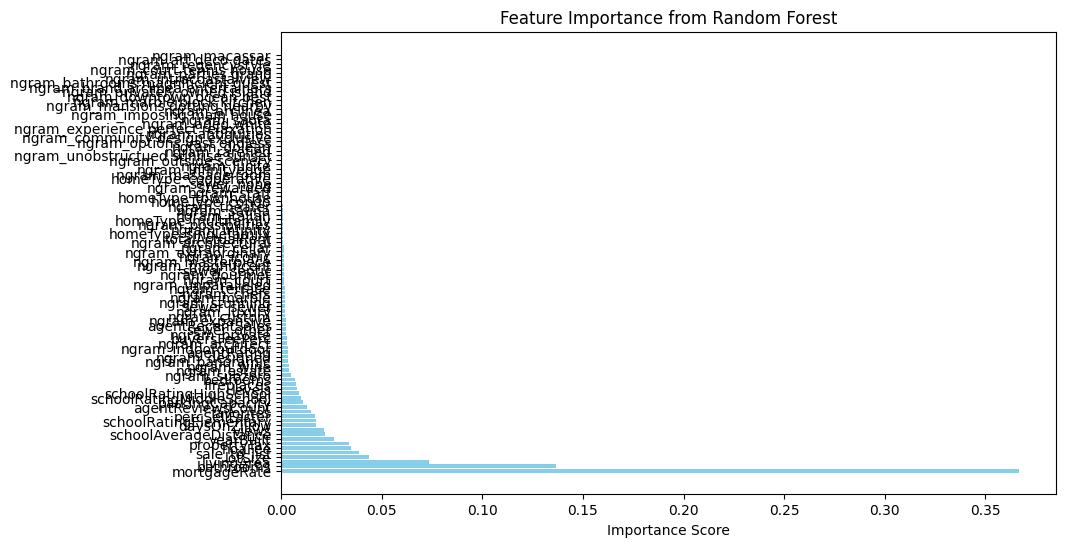

In [27]:
X = final_df.drop(columns=['selling_price'])
y = final_df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from Random Forest')
plt.show()

### 2. Permutation Feature Importance

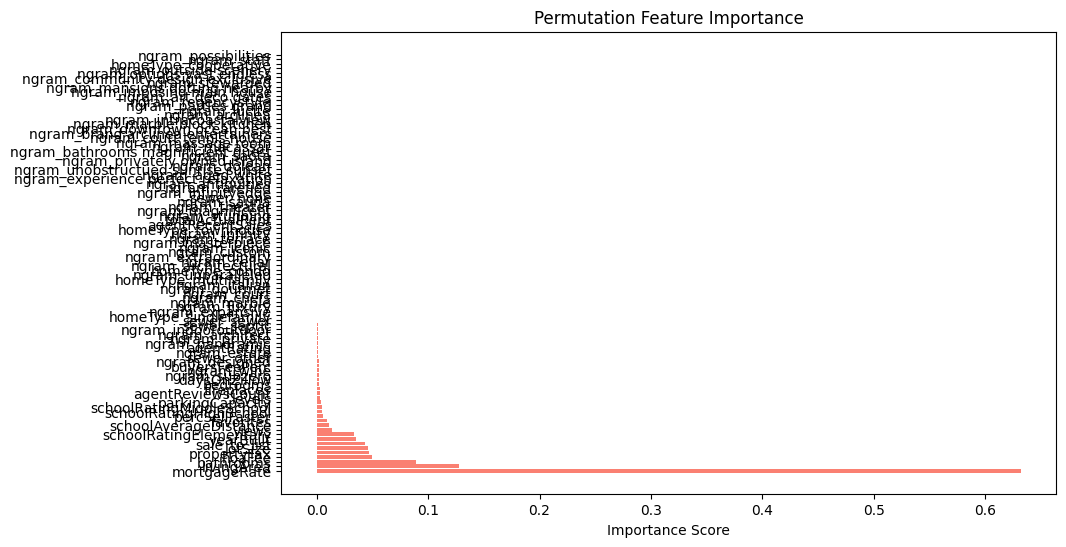

In [28]:
rf_model.fit(X_train, y_train)

perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=30, random_state=42)

perm_importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance'], color='salmon')
plt.xlabel('Importance Score')
plt.title('Permutation Feature Importance')
plt.show()

In [41]:
feature_importance_df.head()

,feature,importance
24,mortgageRate,0.367026
10,bathrooms,0.136759
12,livingArea,0.073234
16,lotSize,0.043745
33,sale_to_list,0.038467


In [52]:
perm_importance_df.head()

,feature,importance
24,mortgageRate,0.632040
12,livingArea,0.127991
10,bathrooms,0.089567
17,hoaFee,0.049500
23,propertyTax,0.046610


## Baseline Model
- Based on the feature importance analysis, the top three features—'mortgageRate', 'bathrooms', and 'livingArea'—are consistent across both methods. I will use these three features to build the baseline model.

In [51]:
features = final_df[['mortgageRate', 'bathrooms', 'livingArea']]
target = final_df['selling_price']

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_imputed, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error (MAE): 285248.2656544117
Mean Squared Error (MSE): 246667648228.15436
Root Mean Squared Error (RMSE): 496656.469028799
R^2 Score: 0.41624748359909947


In [54]:
selected_features = ['mortgageRate', 'bathrooms', 'livingArea', 'lotSize', 'yearBuilt', 'hoaFee', 'propertyTax', 'sale_to_list']
X = final_df[selected_features]
y = final_df['selling_price']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

ridge = Ridge()
params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(ridge, param_grid=params, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

y_pred = ridge_cv.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Alpha: {ridge_cv.best_params_['alpha']}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Best Alpha: 0.1
Mean Absolute Error (MAE): 280446.8086811852
Mean Squared Error (MSE): 245320517566.20297
Root Mean Squared Error (RMSE): 495298.412642523
R^2 Score: 0.4194355421851511


In [55]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Mean Absolute Error (MAE): 152165.1371908825
Mean Squared Error (MSE): 103278516625.92593
Root Mean Squared Error (RMSE): 321369.7506392379
R^2 Score: 0.7555857267720316
